In [1]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 
import seaborn as sns

In [2]:
sc = "sc01"
period = "2030"
case= "RTS24"
folder = f"../Data/{case}_DC_fy/"

all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.3
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in=dfs_in, dfs_out=dfs_out, dfs_inter_j=dfs_inter_j,executions=all_executions,normalize_out=True)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
90
input_f_sc01_Network_Full_Generation_Full_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_102_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_103_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_105_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_104_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_106_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_124_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_104_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_105_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_107_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_110_cac1_2030.csv
90
input_

In [13]:
#Calculate some overall metrics such as variance 
torch.mean(t_in_fy,axis = 0)
print("Input standard dev:", torch.std(t_in_fy,axis = 0))

torch.mean(t_inter_fy,axis = 0)
print("Intermediate layer standard dev:",torch.std(t_inter_fy,axis = 0))

print("Output standard dev:",torch.std(t_out_fy,axis = 0))
torch.mean(t_out_fy,axis = 0)


Input standard dev: tensor([0.3657, 0.3641, 0.3653, 0.3601, 0.3635, 0.3642, 0.3154, 0.3607, 0.3678,
        0.3191, 0.3163, 0.3190, 0.3137, 0.3193, 0.3159, 0.3237, 0.3091, 0.3175,
        0.3173, 0.3142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3653,
        0.1440, 0.1440, 0.1440, 0.1440, 0.1440, 0.1440, 0.1440, 0.1440, 0.1440,
        0.1440, 0.0000, 0.0000, 0.1440, 0.1440, 0.1440, 0.1440, 0.0000, 0.1440,
        0.1440, 0.1440, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       dtype=torch.float64)
Intermediate layer standard dev: tensor([0.1846, 0.2179, 0.3530, 0.2441, 0.2922, 0.1893, 0.2326, 0.2532, 0.2730,
        0.1841, 0.2425, 0.2055, 0.2170

tensor(0.0158, dtype=torch.float64)

In [14]:
np_out_original_full = t_out_fy.numpy()*maxs["out_scalar"].numpy()

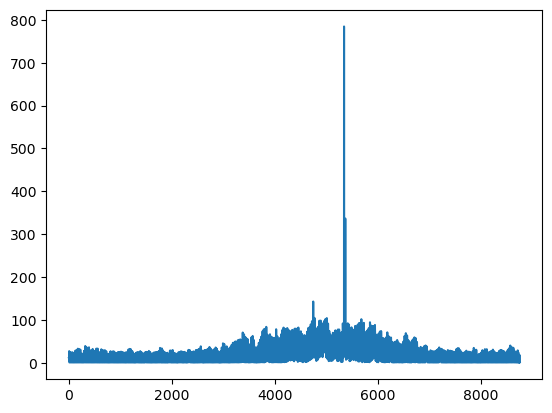

In [15]:
plt.plot(np_out_original_full[0:8760])

In [16]:
#Look at the average difference and percentual deviation incurred by installing all candidates
existing_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[0],dfs_out)/maxs["out_scalar"]
full_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[1],dfs_out)/maxs["out_scalar"]

differences = existing_actual - full_actual
deviation_existing = torch.div(differences,existing_actual) 

print(torch.mean(deviation_existing),torch.median(deviation_existing), torch.std(deviation_existing))
#plt.boxplot(differences.detach().numpy())
#plt.boxplot(deviation_existing.detach().numpy())

tensor(0.4010, dtype=torch.float64) tensor(0.2337, dtype=torch.float64) tensor(0.3771, dtype=torch.float64)


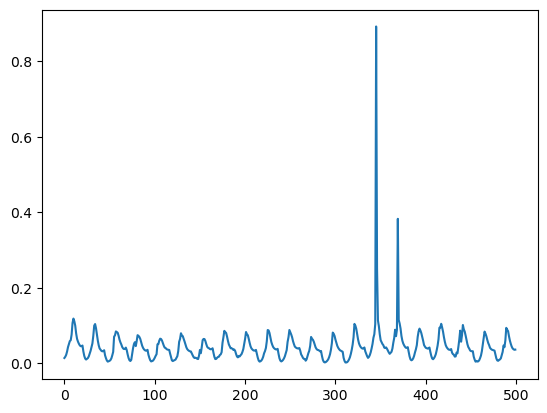

In [17]:
plt.plot(existing_actual[5000:5500])
#plt.plot(full_actual)
#plt.plot(differences)

In [18]:
#Collect difference and deviation incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
for ic in ics:
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]

    ex_actual_P = NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out)/maxs["out_scalar"]
    ex_actual_T = NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)/maxs["out_scalar"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)
    print(ic, "PINT: ", lb_P.sum().item(),"TOOT:",lb_T.sum().item())

    lb = (lb_P + lb_T)/2
    df_lb[ic] = lb
    #ic,ex_P,ex_T,lb.sum()
df_lb_dev = df_lb.div(existing_actual,axis=0)

N_101_N_102_cac1 PINT:  -0.010670835701521279 TOOT: -0.0019388914257595165
N_101_N_103_cac1 PINT:  -0.5152647559386263 TOOT: -0.10757143669345778
N_101_N_105_cac1 PINT:  -0.061968595592738415 TOOT: 0.00046399417887322506
N_102_N_104_cac1 PINT:  -0.0006119093589996749 TOOT: 0.002955782748516878
N_102_N_106_cac1 PINT:  -0.0908710764399161 TOOT: 0.002637501557014427
N_103_N_109_cac1 PINT:  -0.410442730196161 TOOT: -0.11080886355734364
N_103_N_124_cac1 PINT:  -6.009733228582405 TOOT: -0.5344665439459617
N_104_N_109_cac1 PINT:  0.04139970512276473 TOOT: 0.008422995376953988
N_105_N_110_cac1 PINT:  0.07952303380387442 TOOT: 0.019009868129412914
N_106_N_108_cac1 PINT:  -0.025758427604322155 TOOT: -0.001660742504840179
N_106_N_110_cac1 PINT:  0.08869367787220685 TOOT: 0.010492463013138484
N_107_N_108_cac1 PINT:  10.90267291173012 TOOT: 2.9627666721076267
N_108_N_109_cac1 PINT:  0.03917889823816305 TOOT: -0.0033545158417240136
N_108_N_110_cac1 PINT:  -0.07234789001189523 TOOT: -0.00082707171293

In [43]:
#Model deviations
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_20"
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_80"
hour_limit = 5000
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses.Nb_hours_used <=hour_limit

loss_to_sort = "Te_l_mse"
xth_best = 1

row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
if row.Sel_method.item() == "Hours": 
    hyperloop_name = f"Decay_rand_Hours_{case}_DC_0.25_v0.33_PF_0_80"
elif row.Sel_method.item() == "Days":
    hyperloop_name = f"Decay_rand_Days_{case}_DC_0.25_v0.33_PF_0_80"
else: 
    print("Problem")

m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes = [60,60,60,38,19])
prediction = m(t_in_fy.float())[0].squeeze().detach().numpy()

diff = prediction - t_out_fy.numpy().transpose()
dev = diff/prediction

[60, 60, 60, 38, 19]
OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE min_val
trained_models/Decay_rand_Days_RTS24_DC_0.25_v0.33_PF_0_80/min_val/model_OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE.pth


{'whiskers': [<matplotlib.lines.Line2D at 0x1a9b122c2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a9b122c820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a9b122c040>],
 'medians': [<matplotlib.lines.Line2D at 0x1a9b122cd60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a9b122d000>],
 'means': []}

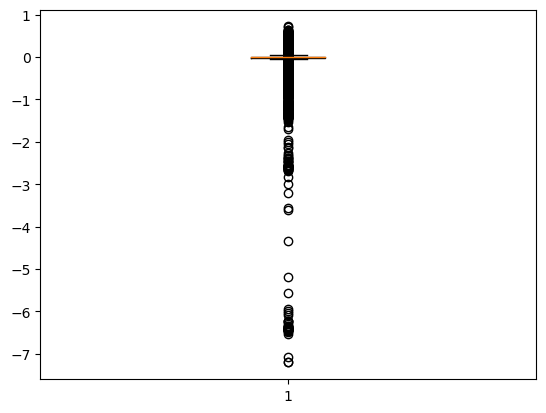

In [44]:
plt.boxplot(dev)

In [45]:
def get_exec_indices_PT(ic,all_executions):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]
    return ex_P,ex_T
    
def get_lb_actual_PT(ic,dfs_out,all_executions,maxs): 
    ex_P,ex_T = get_exec_indices_PT(ic,all_executions)

    ex_actual_P = (NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out) - maxs["out_shift"])/maxs["out_scalar"]
    ex_actual_T = (NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)- maxs["out_shift"])/maxs["out_scalar"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)

    lb = (lb_P + lb_T)/2
    return lb
def get_lb_estimated_PT(m,ic,dfs_in,all_executions,maxs):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]


    est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
    est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

    est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
    est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

    lb_P =  est_exis-est_ic_P
    lb_T = - (est_full - est_ic_T)
    lb = (lb_P + lb_T)/2
    return lb

In [46]:
ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
ex_P  = all_executions[ix_P[0]]
ex_T = all_executions[ix_T[0]]


est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

lb_P =  est_exis-est_ic_P
lb_T = - (est_full - est_ic_T)
lb = (lb_P + lb_T)/2
lb.sum()

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


-2.1474576

In [47]:
#Collect both actual and estimated line benefits incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
sums_lb = pd.DataFrame()
i=0
for ic in ics:
    lb_actual = get_lb_actual_PT(ic = ic,dfs_out=dfs_out,all_executions=all_executions,maxs = maxs)
    lb_est = get_lb_estimated_PT(m=m,ic=ic,dfs_in=dfs_in,all_executions=all_executions,maxs=maxs)

    df_lb[f"{ic}_actual"] = lb_actual
    df_lb[f"{ic}_estimate"] = lb_est
    correl = np.corrcoef(lb_actual,lb_est)[0,1]
    row_act = pd.DataFrame({"LB sum": lb_actual.sum().item(),"AE":"Actual","IC":ic,"Correl": correl },index = [i])
    i+=1
    row_est = pd.DataFrame({"LB sum": lb_est.sum(),"AE":"Estimate","IC":ic,"Correl": correl},index = [i])
    i+=1
    sums_lb = pd.concat([sums_lb,row_act,row_est])

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.recipro

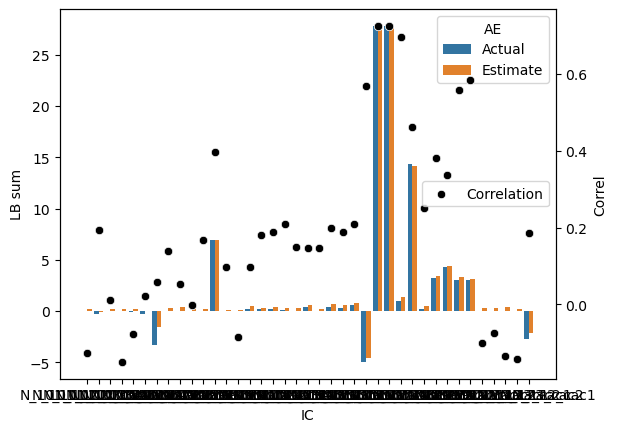

In [48]:
fig, ax = plt.subplots()
sns.barplot(data = sums_lb,x = "IC",y = "LB sum",hue = "AE")

ax2 = ax.twinx()
sns.scatterplot(x='IC', y='Correl', data=sums_lb, color='black', markers=True, ax=ax2,label = "Correlation")
ax2.legend(loc="right")
plt.savefig(f"Figures/LineBenefits/Summed_Benefits_and_correl_{case}_{hour_limit}")

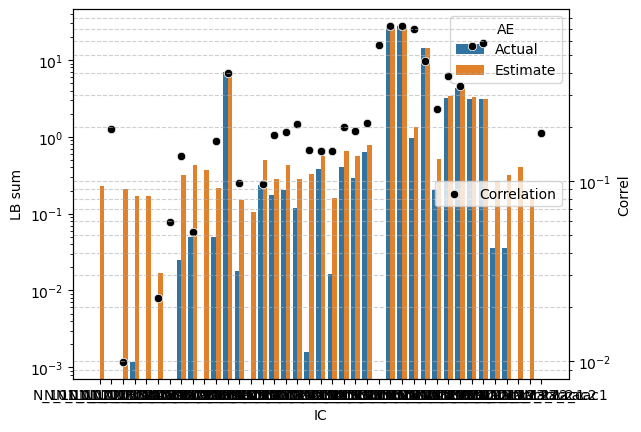

In [26]:
fig, ax = plt.subplots()

# Create the bar plot with a logarithmic y-axis
sns.barplot(data=sums_lb, x="IC", y="LB sum", hue="AE", ax=ax)
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale

ax2 = ax.twinx()

# Create the scatter plot with a logarithmic y-axis
sns.scatterplot(x='IC', y='Correl', data=sums_lb, color='black', markers=True, ax=ax2,label = "Correlation")
ax2.set_yscale('log')  # Set the y-axis of the second plot to a logarithmic scale
ax2.grid(True, axis='y', linestyle='--', alpha=0.6,which = "both")  # Add grid lines to the y-axis of the second plot
plt.savefig(f"Figures/LineBenefits/Summed_Benefits_and_correl_{case}_{hour_limit}_log")
ax2.legend(loc="right")
plt.show()

N_101_N_102_cac1_actual     -0.006305
N_101_N_102_cac1_estimate    0.231927
N_101_N_103_cac1_actual     -0.311418
N_101_N_103_cac1_estimate   -0.069379
N_101_N_105_cac1_actual     -0.030752
                               ...   
N_120_N_123_cac1_estimate    0.407142
N_120_N_123_cac2_actual     -0.008833
N_120_N_123_cac2_estimate    0.167606
N_121_N_122_cac1_actual     -2.725661
N_121_N_122_cac1_estimate   -2.147458
Length: 78, dtype: float64


0.022492989707253153

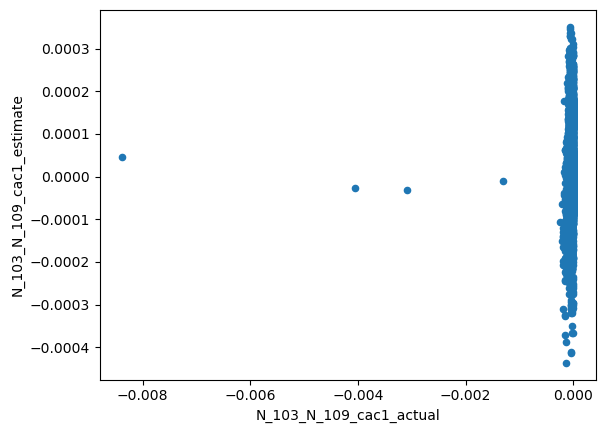

In [27]:
candidate = ics[5]
df_lb.plot.scatter(x=f"{candidate}_actual",y=f"{candidate}_estimate")
ics_only = df_losses[f][["Te_l_mse","fy_l_mse"]]
correl = df_lb.corr().loc[f"{candidate}_actual",f"{candidate}_estimate"]
correl